# Latent Diffusion Bridges for Unsupervised Musical Audio Timbre Transfer Demo

[Source code](https://github.com/sony/diffusion-timbre-transfer)

[Supplementary Material](./Appendix.pdf)

## Table of Contents

1. [Timbre Transfer Results](#timbre-transfer-results)  
   1.1. [Normal Instruments Created with Our Method](#normal-instruments-created-with-our-method)  
   1.2. [Pitch-Shifted Flute](#pitch-shifted-flute)  
   1.3. [Chunk-Based Minibatch](#chunk-based-minibatch)  

2. [Impact of Different Sigma Max and Sigma N](#impact-of-different-sigma-max-and-sigma-n)  

3. [Shared Space](#shared-space)  
4. [Cycle Consistency](#cycle-consistency)  
5. [Appendix](./Appendix.pdf)



<a id="timbre-transfer-results"></a>

## Timbre Transfer Results




<a id="normal-instruments-created-with-our-method"></a>

### Normal Instruments Created with Our Method



In [1]:
import warnings
warnings.filterwarnings('ignore')

import sys
import os

from IPython.display import display, HTML, Audio
import matplotlib.pyplot as plt
import numpy as np
import io
import base64
import json

In [2]:
html_table = "<table style='width:100%; table-layout: fixed; border-collapse: collapse;'>"

# Add CSS for hover effect
html_table += """
<style>
    .hover-image {
        width: 50%; /* Set default width to be smaller */
        transition: transform 0.3s ease; /* Smooth transition */
    }
    .hover-image:hover {
        transform: scale(2.5); /* Scale the image to 120% on hover */
        z-index: 1; /* Ensure the image is above other elements */
    }
</style>
"""

# Start the header row
html_table += """
    <tr>
        <th style="text-align: center; width: 50%; border: 1px solid #ddd; padding: 8px;">Source</th>
        <th style="text-align: center; width: 50%; border: 1px solid #ddd; padding: 8px;">Target</th>
    </tr>
"""

# By default the path for files is hardcoded in ./media/exp_dir
exp_dir = 'normal_instruments'

# Key is name of the file in the first column, value is the name of the files in the second columns (given the rows are merged
# for some of the examples)
pairs_to_show = {
    'flute': ['violin', 'trumpet'],
    'violin': ['flute', 'trumpet'],
    'trumpet': ['flute', 'violin'],
    'bassoon': ['cello'],
    'cello': ['bassoon']
}

# Repetition of file names with (DPD and JD)
distance_metrics = {
    ('flute', 'violin'): (0.07, 0.0),
    ('flute', 'trumpet'): (0.05, 0.0),
    ('violin', 'flute'): (0.1, 0.2),
    ('violin', 'trumpet'): (0.13, 0.1),
    ('trumpet', 'flute'): (0.02, 0.0),
    ('trumpet', 'violin'): (0.02, 0.0),
    ('bassoon', 'cello'): (0.12, 0.0),
    ('cello', 'bassoon'): (0.07, 0.0)
}

# Iterate over the dictionary
for source_instrument, target_instruments in pairs_to_show.items():
    rowspan = len(target_instruments)  # Number of targets for this source instrument

    for i, target_instrument in enumerate(target_instruments):
        # Start the row
        html_table += "<tr>"

        # Add the source instrument in the first column with rowspan if it's the first row for this source
        if i == 0:
            html_table += f"""
                <td rowspan="{rowspan}" style="vertical-align: middle; text-align: center; border: 1px solid #ddd; padding: 8px;">
                    <div style="font-weight: bold;">{source_instrument}</div>
                    <div style="margin-top: 5px; height: 25px;"></div> 
                    <div style="margin-top: 5px;">
                        <audio controls>
                            <source src="media/{exp_dir}/real_{source_instrument}.wav" type="audio/wav">
                        </audio>
                    </div>
                    <div style="margin-top: 10px;">
                        <img src="media/{exp_dir}/real_{source_instrument}_pitch.png" alt="{source_instrument} pitch contour" class="hover-image">
                    </div>
                </td>
            """

        # Add the target instrument in the second column
        dpd, jd = distance_metrics[(source_instrument, target_instrument)]

        html_table += f"""
            <td style="vertical-align: top; text-align: center; border: 1px solid #ddd; padding: 8px;">
                <div style="font-weight: bold;">{target_instrument}</div>
                <div style="margin-top: 5px;">DPD: {round(dpd, 2)}, JD: {round(jd, 2)}</div>
                <div style="margin-top: 10px;">
                    <audio controls>
                        <source src="media/{exp_dir}/generated_{target_instrument}_from_{source_instrument}.wav" type="audio/wav">
                    </audio>
                </div>
                <div style="margin-top: 10px;">
                    <img src="media/{exp_dir}/generated_{target_instrument}_from_{source_instrument}_pitch.png" alt="{target_instrument} pitch contour" class="hover-image">
                </div>
            </td>
        """

        # End the row
        html_table += "</tr>"

# End the table
html_table += "</table>"

# Display the HTML table
display(HTML(html_table))


<a id="pitch-shifted-flute"></a>

### Pitch-Shifted



In [3]:
html_table = "<table style='width:100%; table-layout: fixed; border-collapse: collapse;'>"

# Add CSS for hover effect
html_table += """
<style>
    .hover-image {
        width: 50%; /* Set default width to be smaller */
        transition: transform 0.3s ease; /* Smooth transition */
    }
    .hover-image:hover {
        transform: scale(2.5); /* Scale the image to 250% on hover */
        z-index: 1; /* Ensure the image is above other elements */
    }
</style>
"""

# Start the header row
html_table += """
    <tr>
        <th style="text-align: center; width: 50%; border: 1px solid #ddd; padding: 8px;">Source</th>
        <th style="text-align: center; width: 50%; border: 1px solid #ddd; padding: 8px;">Target</th>
    </tr>
"""

exp_dir = 'pitch_shifted'
pairs_to_show = {
    'flute_shifted_0': ['bassoon'],
    'flute_shifted_20': ['bassoon'],
    'flute_shifted_25': ['bassoon']
}

descriptions = [
    'flute shifted 0 semitones',
    'flute shifted -20 semitones',
    'flute shifted -25 semitones'
]

distance_metrics = {
    ('flute_shifted_0', 'bassoon'): (0.75, 0.08),
    ('flute_shifted_20', 'bassoon'): (0.6, 0.25),
    ('flute_shifted_25', 'bassoon'): (0.12, 0.0)
}

# Iterate over the dictionary
for index, (source_instrument, target_instruments) in enumerate(pairs_to_show.items()):
    rowspan = len(target_instruments)  # Number of targets for this source instrument

    for i, target_instrument in enumerate(target_instruments):
        # Start the row
        html_table += "<tr>"

        # Add the source instrument in the first column with rowspan if it's the first row for this source
        if i == 0:
            html_table += f"""
                <td rowspan="{rowspan}" style="vertical-align: middle; text-align: center; border: 1px solid #ddd; padding: 8px;">
                    <div style="font-weight: bold;">{descriptions[index]}</div>
                    <div style="margin-top: 5px; height: 25px;"></div> 
                    <div style="margin-top: 5px;">
                        <audio controls>
                            <source src="media/{exp_dir}/real_{source_instrument}.wav" type="audio/wav">
                        </audio>
                    </div>
                    <div style="margin-top: 10px;">
                        <img src="media/{exp_dir}/real_{source_instrument}_pitch.png" alt="{source_instrument} pitch contour" class="hover-image">
                    </div>
                </td>
            """

        # Add the target instrument in the second column
        dpd, jd = distance_metrics[(source_instrument, target_instrument)]

        html_table += f"""
            <td style="vertical-align: top; text-align: center; border: 1px solid #ddd; padding: 8px;">
                <div style="font-weight: bold;">{target_instrument}</div>
                <div style="margin-top: 5px;">DPD: {round(dpd, 2)}, JD: {round(jd, 2)}</div>
                <div style="margin-top: 10px;">
                    <audio controls>
                        <source src="media/{exp_dir}/generated_{target_instrument}_from_{source_instrument}.wav" type="audio/wav">
                    </audio>
                </div>
                <div style="margin-top: 10px;">
                    <img src="media/{exp_dir}/generated_{target_instrument}_from_{source_instrument}_pitch.png" alt="{target_instrument} pitch contour" class="hover-image">
                </div>
            </td>
        """

        # End the row
        html_table += "</tr>"

# End the table
html_table += "</table>"

# Display the HTML table
display(HTML(html_table))


Source,Target
flute shifted 0 semitones,"bassoon DPD: 0.75, JD: 0.08"
flute shifted -20 semitones,"bassoon DPD: 0.6, JD: 0.25"
flute shifted -25 semitones,"bassoon DPD: 0.12, JD: 0.0"


<a id="chunk-based-minibatch"></a>

### Chunk-Based Minibatch



In [4]:
html_table = "<table style='width:100%; table-layout: fixed; border-collapse: collapse;'>"

# Add CSS for hover effect
html_table += """
<style>
    .hover-image {
        width: 50%; /* Set default width to be smaller */
        transition: transform 0.3s ease; /* Smooth transition */
    }
    .hover-image:hover {
        transform: scale(2.5); /* Scale the image to 250% on hover */
        z-index: 1; /* Ensure the image is above other elements */
    }
</style>
"""

# Start the header row
html_table += """
    <tr>
        <th style="text-align: center; width: 50%; border: 1px solid #ddd; padding: 8px;">Source</th>
        <th style="text-align: center; width: 50%; border: 1px solid #ddd; padding: 8px;">Target</th>
    </tr>
"""

exp_dir = 'chunk_based_minibatch'
pairs_to_show = {
    'flute_time_4_channel_0': ['violin'],
    'flute_time_4_channel_32': ['violin'],
    'violin_time_4_channel_0': ['flute'],
    'violin_time_4_channel_32': ['flute'],
}

descriptions = [
    'model trained with time chunk size 4 and channel chunk size 0',
    'model trained with time chunk size 4 and channel chunk size 32',
    'model trained with time chunk size 4 and channel chunk size 0',
    'model trained with time chunk size 4 and channel chunk size 32',
]

distance_metrics = {
    ('flute_time_4_channel_0', 'violin'): (0.12, 0.00),
    ('flute_time_4_channel_32', 'violin'): (0.2, 0.0),
    ('violin_time_4_channel_0', 'flute'): (0.09, 0.0),
    ('violin_time_4_channel_32', 'flute'): (0.13, 0.1)
}

# Iterate over the dictionary
for index, (source_instrument, target_instruments) in enumerate(pairs_to_show.items()):
    rowspan = len(target_instruments)  # Number of targets for this source instrument

    for i, target_instrument in enumerate(target_instruments):
        # Start the row
        html_table += "<tr>"

        # Add the source instrument in the first column with rowspan if it's the first row for this source
        if i == 0:
            html_table += f"""
                <td rowspan="{rowspan}" style="vertical-align: middle; text-align: center; border: 1px solid #ddd; padding: 8px;overflow: visible;">
                    <div style="font-weight: bold;">{source_instrument.split('_')[0]}</div>
                    <div style="margin-top: 5px;">{descriptions[index]}</div>
                    <div style="margin-top: 5px;">
                        <audio controls>
                            <source src="media/{exp_dir}/real_{source_instrument}.wav" type="audio/wav">
                        </audio>
                    </div>
                    <div style="margin-top: 10px;overflow: visible;">
                        <img src="media/{exp_dir}/real_{source_instrument}_pitch.png" alt="{source_instrument} pitch contour" class="hover-image">
                    </div>
                </td>
            """

        # Add the target instrument in the second column
        dpd, jd = distance_metrics[(source_instrument, target_instrument)]

        html_table += f"""
            <td style="vertical-align: top; text-align: center; border: 1px solid #ddd; padding: 8px; overflow: visible;">
                <div style="font-weight: bold;">{target_instrument}</div>
                <div style="margin-top: 5px;">DPD: {round(dpd, 2)}, JD: {round(jd, 2)}</div>
                <div style="margin-top: 10px;">
                    <audio controls>
                        <source src="media/{exp_dir}/generated_{target_instrument}_from_{source_instrument}.wav" type="audio/wav">
                    </audio>
                </div>
                <div style="margin-top: 10px;overflow: visible;">
                    <img src="media/{exp_dir}/generated_{target_instrument}_from_{source_instrument}_pitch.png" alt="{target_instrument} pitch contour" class="hover-image">
                </div>
            </td>
        """

        # End the row
        html_table += "</tr>"

# End the table
html_table += "</table>"

# Display the HTML table
display(HTML(html_table))


Source,Target
flute model trained with time chunk size 4 and channel chunk size 0,"violin DPD: 0.12, JD: 0.0"
flute model trained with time chunk size 4 and channel chunk size 32,"violin DPD: 0.2, JD: 0.0"
violin model trained with time chunk size 4 and channel chunk size 0,"flute DPD: 0.09, JD: 0.0"
violin model trained with time chunk size 4 and channel chunk size 32,"flute DPD: 0.13, JD: 0.1"


<a id="impact-of-different-sigma-max-and-sigma-n"></a>

## Impact of Different Sigma Max and Sigma N



In [5]:
html_table = f"""
<table style="width:100%; table-layout: fixed; border-collapse: collapse;">
    <tr>
        <th style="text-align: center; border: 1px solid #ddd; padding: 8px;">Source</th>
        <th style="text-align: center; border: 1px solid #ddd; padding: 8px;">Noise</th>
        <th style="text-align: center; border: 1px solid #ddd; padding: 8px;">Target</th>
    </tr>
"""

exp_dir = 'different_sigma_max'
pairs_to_show = {
    'violin_sigma_max=100_sigma_N=100': ['flute'],
    'violin_sigma_max=100_sigma_N=50': ['flute'],
    'violin_sigma_max=100_sigma_N=20': ['flute'],
    'violin_sigma_max=100_sigma_N=5': ['flute'],
}

distance_metrics = {
    ('violin_sigma_max=100_sigma_N=100', 'flute'): (2.39, 0.64),
    ('violin_sigma_max=100_sigma_N=50', 'flute'): (2.61, 0.82),
    ('violin_sigma_max=100_sigma_N=20', 'flute'): (0.33, 0.1),
    ('violin_sigma_max=100_sigma_N=5', 'flute'): (0.12, 0.1),
}
model_descr_list = [
    'model with sigma_max=100 and sigma_N=100',
    'model with sigma_max=100 and sigma_N=50',
    'model with sigma_max=100 and sigma_N=20',
    'model with sigma_max=100 and sigma_N=5'
]

# Iterate over the pairs to show
for source_instrument, target_instruments in pairs_to_show.items():
    for target_instrument in target_instruments:
        dpd, jd = distance_metrics[(source_instrument, target_instrument)]

        model_descr = model_descr_list.pop(0)  # Adjust this logic as necessary

        # Paths for media files
        audio_html_real = f"real_{source_instrument}.wav"
        spectrogram_real_html = f"real_{source_instrument}_spec.png"
        img1 = f"real_{source_instrument}_pitch.png"

        noise_html = f"noisy_{source_instrument}.wav"
        spectrogram_noise_html = f"noisy_{source_instrument}_spec.png"

        audio_html_generated = f"generated_{target_instrument}_from_{source_instrument}.wav"
        spectrogram_generated_html = f"generated_{target_instrument}_from_{source_instrument}_spec.png"
        img2 = f"generated_{target_instrument}_from_{source_instrument}_pitch.png"

        # Create the HTML table row
        html_table += f"""
        <tr>
            <td style="vertical-align: top; text-align: center; border: 1px solid #ddd; padding: 8px;">
                <div style="font-weight: bold;">{source_instrument.split('_')[0]}</div>
                <div style="margin-top: 5px;">{model_descr}</div>
                <div style="margin-top: 10px;">
                    <audio controls>
                        <source src="media/{exp_dir}/{audio_html_real}" type="audio/wav">
                    </audio>
                </div>
                <div style="margin-top: 10px;">
                    <img src="media/{exp_dir}/{spectrogram_real_html}" alt="{source_instrument} spectrogram" style="width:100%;">
                </div>
                <div style="margin-top: 10px;">
                    <img src="media/{exp_dir}/{img1}" alt="{source_instrument} pitch contour" style="width:100%;">
                </div>
            </td>
            <td style="vertical-align: top; text-align: center; border: 1px solid #ddd; padding: 8px;">
                <div style="font-weight: bold;">Noisy {source_instrument.split('_')[0]}</div>
                <div style="margin-top: 5px; height: 16px;"></div> 
                <div style="margin-top: 10px;">
                    <audio controls>
                        <source src="media/{exp_dir}/{noise_html}" type="audio/wav">
                    </audio>
                </div>
                <div style="margin-top: 10px;">
                    <img src="media/{exp_dir}/{spectrogram_noise_html}" alt="Noisy {source_instrument} spectrogram" style="width:100%;">
                </div>
            </td>
            <td style="vertical-align: top; text-align: center; border: 1px solid #ddd; padding: 8px;">
                <div style="font-weight: bold;">{target_instrument}</div>
                <div style="margin-top: 5px;">DPD: {round(dpd, 2)}, JD: {round(jd, 2)}</div>
                <div style="margin-top: 10px;">
                    <audio controls>
                        <source src="media/{exp_dir}/{audio_html_generated}" type="audio/wav">
                    </audio>
                </div>
                <div style="margin-top: 10px;">
                    <img src="media/{exp_dir}/{spectrogram_generated_html}" alt="{target_instrument} spectrogram" style="width:100%;">
                </div>
                <div style="margin-top: 10px;">
                    <img src="media/{exp_dir}/{img2}" alt="{target_instrument} pitch contour" style="width:100%;">
                </div>
            </td>
        </tr>
        """

# End the table
html_table += "</table>"

# Display the HTML table
display(HTML(html_table))


Source,Noise,Target
violin model with sigma_max=100 and sigma_N=100,Noisy violin,"flute DPD: 2.39, JD: 0.64"
violin model with sigma_max=100 and sigma_N=50,Noisy violin,"flute DPD: 2.61, JD: 0.82"
violin model with sigma_max=100 and sigma_N=20,Noisy violin,"flute DPD: 0.33, JD: 0.1"
violin model with sigma_max=100 and sigma_N=5,Noisy violin,"flute DPD: 0.12, JD: 0.1"


In [6]:
path_json ='media/sigma_max_vs_pitch_distance.json'
with open(path_json, 'r') as f:
    data = json.load(f)

In [7]:
# Convert every value in np array
data = {k: np.array(v) for k, v in data.items()}

This graph illustrates the JD and DPD values for a specific violin-to-flute timbre transfer example while varying sigma_N. The classification of the generated audio as either violin or flute is also indicated.

In [8]:
# First plot: Jaccard vs Sigma_max
fig1, ax1 = plt.subplots(figsize=(9, 4))
for cls, color, label in zip([0, 1], ['blue', 'orange'], ['Violin', 'Flute']):
    mask = data['predicted_classes'] == cls
    ax1.scatter(data['sigma_max'][mask], data['jaccard'][mask], color=color, label=label)
ax1.set_title('JD vs Sigma_N')
ax1.set_xlabel('Sigma_N')
ax1.set_ylabel('JD')
ax1.legend()

# Save the first plot to a buffer
buf1 = io.BytesIO()
fig1.savefig(buf1, format='png')
buf1.seek(0)
image_base64_1 = base64.b64encode(buf1.read()).decode('utf-8')
buf1.close()
plt.close(fig1)

# Second plot: DTW vs Sigma_max
fig2, ax2 = plt.subplots(figsize=(9, 4))
for cls, color, label in zip([0, 1], ['blue', 'orange'], ['Violin', 'Flute']):
    mask = data['predicted_classes'] == cls
    ax2.scatter(data['sigma_max'][mask], data['dtw'][mask], color=color, label=label)
ax2.set_title('DPD vs Sigma_N')
ax2.set_xlabel('Sigma_N')
ax2.set_ylabel('DPD')
ax2.legend()

# Save the second plot to a buffer
buf2 = io.BytesIO()
fig2.savefig(buf2, format='png')
buf2.seek(0)
image_base64_2 = base64.b64encode(buf2.read()).decode('utf-8')
buf2.close()
plt.close(fig2)



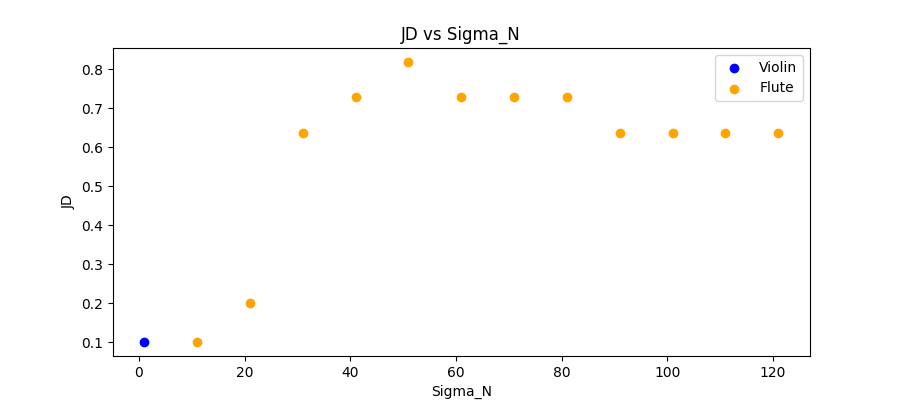
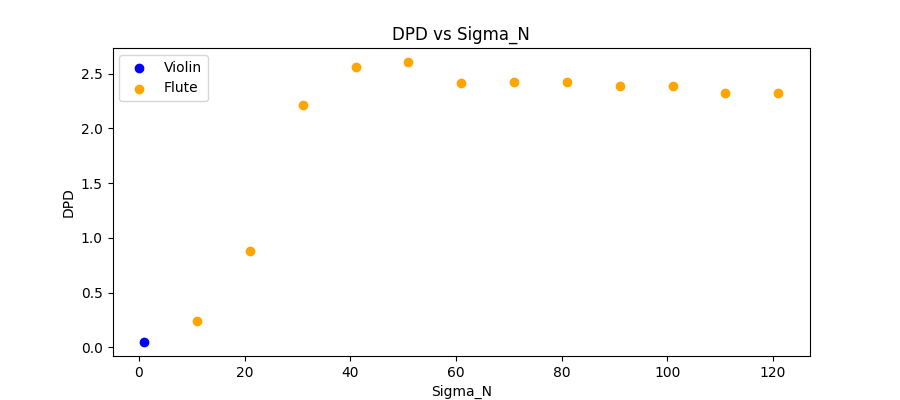

In [9]:
html_content = f"""
<div style="display: grid; grid-template-columns: 1fr 1fr; gap: 20px;">
    <div>
        <img src="data:image/png;base64,{image_base64_1}" alt="Jaccard vs Sigma_max" style="width:100%;">
    </div>
    <div>
        <img src="data:image/png;base64,{image_base64_2}" alt="DTW vs Sigma_max" style="width:100%;">
    </div>
</div>
"""

# Display the HTML content
display(HTML(html_content))


<a id="shared-space"></a>

## Shared Space



The following audio samples were generated using flute and violin models, both with sigma_max=100 and sigma_N=100, by sampling directly from N(0, sigma_max). Below, we provide examples of audio pairs that were considered melodically similar and those that were not.


In [10]:
html_table = f"""
<table style="width:100%; table-layout: fixed; border-collapse: collapse;">
    <tr>
        <th style="text-align: center; border: 1px solid #ddd; padding: 8px;">Source Latent</th>
        <th style="text-align: center; border: 1px solid #ddd; padding: 8px;">Flute</th>
        <th style="text-align: center; border: 1px solid #ddd; padding: 8px;">Violin</th>
    </tr>
"""

exp_dir = 'shared_space'

# Specify the audio names for each row
source_audios = [
    "gaussian_seed_0.wav",
    "gaussian_seed_1.wav",
]

target_audios = [
    ("flute_similiar.wav", "violin_similiar.wav"),
    ("flute_different.wav", "violin_different.wav"),
]

# Specify the descriptions for each row
descriptions = [
    "Standard Gaussian Noise * 100 with seed=0",
    "Standard Gaussian Noise * 100 with seed=1",
]

description_audios = [
    ('Similar Melodies (DPD < 0.7)', f'DPD: {0.52}, JD: {0.18}'),
    ('Different Melodies (DPD >= 0.7)', f'DPD: {1.77}, JD: {0.25}'),
]

# Iterate over the data
for i in range(len(source_audios)):
    source_audio = source_audios[i]
    flute_audio, violin_audio = target_audios[i]
    description = descriptions[i]
    dpd, jd = distance_metrics[('violin_sigma_max=100_sigma_N=100', 'flute')]  # Adjust this logic for different metrics

    # Paths for media files
    spectrogram_real_html = f"{source_audio.replace('.wav', '_spec.png')}"
    img1 = f"{source_audio.replace('.wav', '_pitch.png')}"

    spectrogram_flute_html = f"{flute_audio.replace('.wav', '_spec.png')}"
    img2 = f"{flute_audio.replace('.wav', '_pitch.png')}"

    spectrogram_violin_html = f"{violin_audio.replace('.wav', '_spec.png')}"
    img3 = f"{violin_audio.replace('.wav', '_pitch.png')}"

    # Create the HTML table row
    html_table += f"""
    <tr>
        <td style="vertical-align: top; text-align: center; border: 1px solid #ddd; padding: 8px;">
            <div style="font-weight: bold;">Source Latent</div>
            <div style="margin-top: 5px;">{description}</div>
            <div style="margin-top: 10px;">
                <audio controls>
                    <source src="media/{exp_dir}/{source_audio}" type="audio/wav">
                </audio>
            </div>
        </td>
        <td style="vertical-align: top; text-align: center; border: 1px solid #ddd; padding: 8px;">
            <div style="font-weight: bold;">Flute</div>
            <div style="margin-top: 5px;">{description_audios[i][0]}</div>
            <div style="margin-top: 10px;">
                <audio controls>
                    <source src="media/{exp_dir}/{flute_audio}" type="audio/wav">
                </audio>
            </div>
            <div style="margin-top: 10px;">
                <img src="media/{exp_dir}/{img2}" alt="Flute pitch contour" style="width:100%;">
            </div>
        </td>
        <td style="vertical-align: top; text-align: center; border: 1px solid #ddd; padding: 8px;">
            <div style="font-weight: bold;">Violin</div>
            <div style="margin-top: 5px;">{description_audios[i][1]}</div>
            <div style="margin-top: 10px;">
                <audio controls>
                    <source src="media/{exp_dir}/{violin_audio}" type="audio/wav">
                </audio>
            </div>
            <div style="margin-top: 10px;">
                <img src="media/{exp_dir}/{img3}" alt="Violin pitch contour" style="width:100%;">
            </div>
        </td>
    </tr>
    """

# End the table
html_table += "</table>"

# Display the HTML table
display(HTML(html_table))

Source Latent,Flute,Violin
Source Latent Standard Gaussian Noise * 100 with seed=0,Flute Similar Melodies (DPD < 0.7),"Violin DPD: 0.52, JD: 0.18"
Source Latent Standard Gaussian Noise * 100 with seed=1,Flute Different Melodies (DPD >= 0.7),"Violin DPD: 1.77, JD: 0.25"


<a id="cycle-consistency"></a>

## Cycle Consistency



The following results were obtained by calculating the normalized L2 norm between the input Encodec embeddings derived from flute audio and the generated Encodec embeddings after converting the flute to violin and back to flute.

In [11]:
path_json = 'media/l2_vs_num_steps.json'
with open(path_json, 'r') as f:
    data = json.load(f)


,

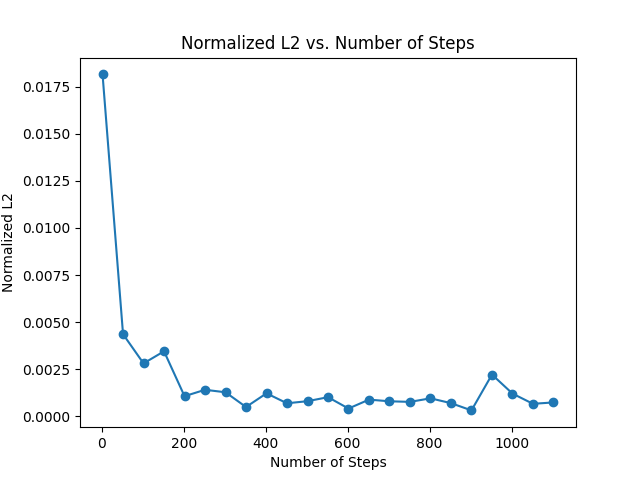
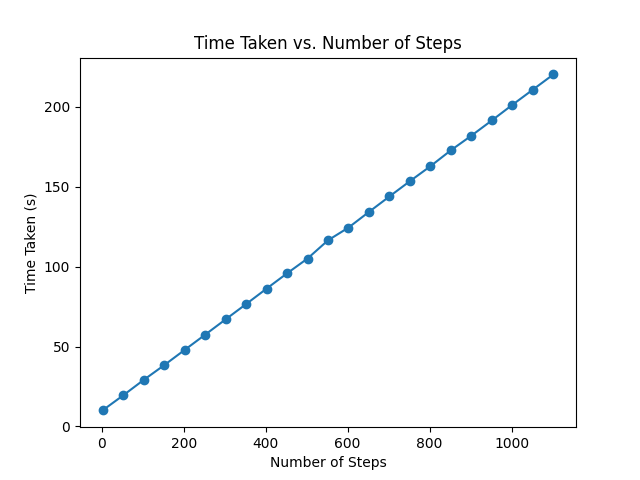

In [12]:

# Function to create the plot and return it as an HTML image
def create_plot(x, y, xlabel, ylabel, title):
    fig, ax = plt.subplots()
    ax.plot(x, y, marker='o')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    
    # Save the plot to a BytesIO object
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)
    img_base64 = base64.b64encode(buf.read()).decode('utf-8')
    buf.close()
    plt.close(fig)
    
    return f'<img src="data:image/png;base64,{img_base64}" />'

# Extract data
num_steps = data['num_steps'][:23]
l2_emb = data['l2_emb']
time_taken = data['time_taken']

# Create the plots
plot1_html = create_plot(num_steps, l2_emb, 'Number of Steps', 'Normalized L2', 'Normalized L2 vs. Number of Steps')
plot2_html = create_plot(num_steps, time_taken, 'Number of Steps', 'Time Taken (s)', 'Time Taken vs. Number of Steps')

# Combine the plots into a grid layout
html_grid = f"""
<table style="width:100%; table-layout: fixed;">
    <tr>
        <td style="text-align: center; vertical-align: top;">
            {plot1_html}
        </td>
        <td style="text-align: center; vertical-align: top;">
            {plot2_html}
        </td>
    </tr>
</table>
"""

# Display the HTML grid
display(HTML(html_grid))